## overview
- predict performance at next step given next domain to practice on

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import copy
import wandb
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random
from scipy.stats import sem

Initialize run

In [2]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Data

In [3]:
df = pd.read_csv("data/filtered_ds.csv")

In [4]:
df["start_time_min"] = df["start_time_min"].astype('datetime64[ns]')
df = df.sort_values(by=["patient_id", "start_time_min"])

Create training data

In [5]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [6]:
## given a dataframe of a single patient, order the sessions by time and returns a dataframe with 14 domain scores
def create_training_data(data : pd.DataFrame):
    score = np.zeros((1, 14)) # continously updated to whatever the newest score is
    scores = np.zeros((len(data), 14)) # remove the last since we dont have target data for it
    domain_code = np.zeros((len(data), 14))
    patient_ids = data["patient_id"].to_numpy().reshape(-1, 1)[1:]
    i = 0 # keeps track of number of rows
    seen = dict() # keeps track of whether or not a domain has been seen
    seen_lst = [] # a list of booleans, if the next domain has been seen, it's true; if not, it's false
    repeat = False # keeps track of whether or not this session is a repeat (practiced domains have been done)

    data = data.sort_values(by=["start_time_min"])

    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)
        for j in range(len(domains)):
            if domains[j] not in seen:
                seen[domains[j]] = True # so that next time its in seen
                repeat = False
            else: repeat = True # if it's already in seen, it's a repeat
            score[0, int(domains[j] - 1)] = domain_scores[j]
        # encode domain worked on
        for d in domains:
            domain_code[i, int(d - 1)] = 1
        # set score
        scores[i, :] = score
        i += 1
        seen_lst.append(repeat)

    
    prev_score = scores[:-1, :]
    next_score = scores[1:, :]
    domain_code = domain_code[1:, :]
    seen_col = np.array(seen_lst)[1:].reshape(-1, 1)

    scores = np.hstack((patient_ids, domain_code))
    scores = np.hstack((scores, prev_score))
    scores = np.hstack((scores, next_score))
    scores = np.hstack((scores, seen_col))
    
    scores_df = pd.DataFrame(scores, columns=["patient_id"] + ["domain %d encoding" % i for i in range(1, 15)] + ["domain %d score" % i for i in range(1, 15)] + ["domain %d target" % i for i in range(1, 15)] + ["repeat"])
    scores_df.reset_index(drop=True, inplace=True)
    return scores_df

In [7]:
data = df.groupby("patient_id")[df.columns].apply(create_training_data).reset_index(drop=True)

In [8]:
## pick a random patient for case study
pid = random.choice(pd.unique(data["patient_id"]))
# pid = 281737
## save the patient's data
case_study_data = copy.deepcopy(data[data['patient_id'] == pid])
## remove the patient's data from the dataset
model_data = data.drop(data[data['patient_id'] == pid].index)

## reset index for the case study
case_study_data = case_study_data.reset_index(drop=True)

In [9]:
model_data = model_data.drop(["patient_id"], axis=1)

In [10]:
def filter_nonzero_rows(df, max_zeros, column_names=["domain %d score" %i for i in range(1, 15)]):
    # only use the score columns when counting 0s
    scores = df[column_names]
    # Count number of zeros in each row
    zeros_count = (scores == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [11]:
# model_data = filter_nonzero_rows(model_data, 0) ## not filtering because we only care about target domains

In [12]:
model_data.shape

(2188969, 43)

In [13]:
train_data, test_data = train_test_split(model_data, test_size=0.25)

In [14]:
def generate_random_array(rows, cols, N):
    if N > cols:
        raise ValueError("N cannot be greater than the number of columns.")
    
    # Create an array of ones with the desired shape
    array = np.ones((rows, cols), dtype=int)
    
    # Randomly assign N zeros to each row
    for i in range(rows):
        indices = np.random.choice(cols, N, replace=False)
        array[i, indices] = 0
    
    return array, array.shape[0] * N

In [15]:
def generate_mask(data, N=10):
    rows, cols = data.shape
    assert(cols == 14)
    mask, n_zeros = generate_random_array(rows, cols, N)
    data = copy.deepcopy(data)
    return data * mask, n_zeros, mask

In [16]:
def generate_differently_masked_data(original_matrix, dupe_n=14):
    score_columns = ["domain %d score" %i for i in range(1, 15)]
    encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
    target_columns = ["domain %d target" %i for i in range(1, 15)]
    final_matrix_lst = [original_matrix.copy()] * dupe_n
    for i in range(14):
        final_matrix_lst[i][score_columns], _, _ = generate_mask(original_matrix[score_columns], N = i)
    final_matrix = pd.concat(final_matrix_lst)
    return copy.deepcopy(final_matrix[encoding_columns + score_columns]), copy.deepcopy(final_matrix[target_columns])

In [17]:
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
target_columns = ["domain %d target" %i for i in range(1, 15)]
repeat_columns = ["repeat"]

In [18]:
# train_data, target = generate_differently_masked_data(train_data, dupe_n=14)
target = train_data[target_columns].copy()
train_data = train_data[encoding_columns + score_columns].copy()

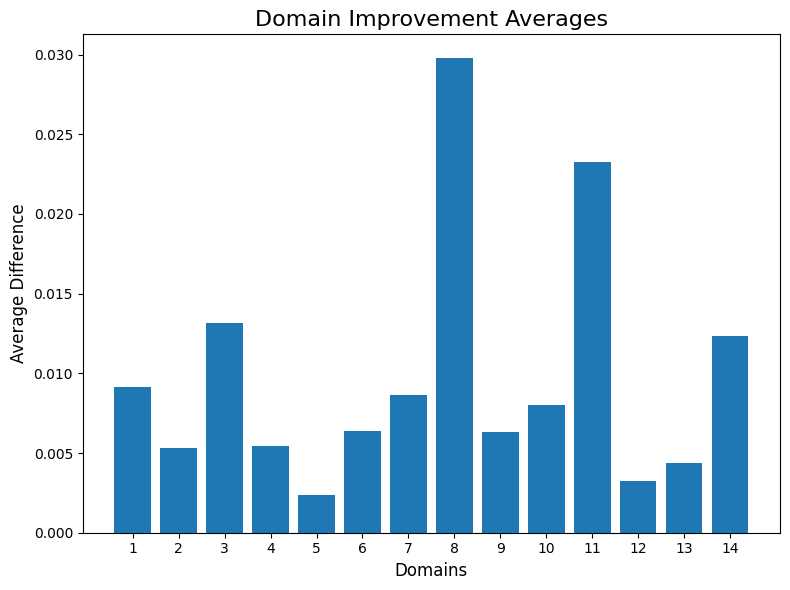

In [19]:
## ground truth
diff = target.to_numpy() * train_data[encoding_columns].to_numpy() - train_data[score_columns].to_numpy() * train_data[encoding_columns].to_numpy()


# Calculate column-wise averages
column_averages = np.sum(diff, axis=0) / np.sum(train_data[encoding_columns].to_numpy(), axis=0)

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
target

,domain 1 target,domain 2 target,domain 3 target,domain 4 target,domain 5 target,domain 6 target,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target
460997,0.543,0.15,0.693,0.586,0.73,0.653,0.85,0.722,0.350,0.107,0.80,0.350,0.085,0.487
1318919,0.000,0.11,0.445,0.000,0.00,0.000,0.00,0.000,0.093,0.000,0.00,0.000,0.362,0.000
666813,1.000,0.84,1.000,0.714,0.50,0.863,0.67,0.817,0.800,1.000,0.00,0.693,1.000,0.853
715845,0.686,0.70,0.000,0.600,0.32,0.000,0.00,0.000,0.560,0.000,0.00,0.821,0.776,0.000
386247,1.000,1.00,0.787,1.000,0.50,0.863,0.55,0.917,0.870,0.871,0.00,0.607,1.000,0.333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003991,0.000,0.61,1.000,0.500,0.25,0.000,0.00,0.000,0.270,0.486,0.76,0.436,0.297,0.000
1570723,0.415,0.79,1.000,0.529,0.14,0.084,0.00,0.000,0.640,0.614,1.00,0.200,0.649,0.000
732180,0.114,0.00,0.467,0.071,0.00,0.032,0.55,0.000,0.000,0.072,0.00,0.400,0.200,0.000
110268,0.757,0.75,1.000,0.143,0.00,0.389,0.27,1.000,0.200,0.821,0.00,0.500,0.727,1.000


In [21]:
train_data = train_data.to_numpy()
target = target.to_numpy()

In [22]:
def create_missing_indicator(data):
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            if p == 0:
                # print("shouldn't be here")
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    return copy.deepcopy(temp)

In [23]:
train_data_scores = create_missing_indicator(train_data[:, -14:])
train_data = np.hstack((train_data[:, :14], train_data_scores))

In [24]:
train_data

array([[0.   , 0.   , 0.   , ..., 0.915, 0.487, 0.513],
       [0.   , 1.   , 0.   , ..., 0.638, 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.853, 0.147],
       ...,
       [0.   , 0.   , 0.   , ..., 0.8  , 1.   , 1.   ],
       [0.   , 0.   , 0.   , ..., 0.273, 1.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.503, 0.913, 0.087]])

In [25]:
train_data[0]

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 1.   , 1.   , 0.   , 0.543, 0.457, 0.15 , 0.85 ,
       0.693, 0.307, 0.586, 0.414, 0.73 , 0.27 , 0.653, 0.347, 0.85 ,
       0.15 , 0.722, 0.278, 0.35 , 0.65 , 0.107, 0.893, 0.8  , 0.2  ,
       0.35 , 0.65 , 0.085, 0.915, 0.487, 0.513])

Model

In [ ]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain)
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, 200),
            torch.nn.Sigmoid(),
            torch.nn.Linear(200, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, n_domains)
        )

    def forward(self, x):
        returnself.model(x)
        return torch.clamp(self.model(x), min=0, max=1)

In [27]:
class customDataset(Dataset):
    def __init__(self, data, target):
        super().__init__()
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index, :], self.target[index, :]

Training

In [28]:
def train_model(x_train, x_val,y_train, y_val, epochs, model, optimizer, loss_function):
    outputs = []
    losses = []
    val_losses = []
    w = 14 ## hardcoded

    data_set = customDataset(x_train, y_train)
    data_loader = DataLoader(data_set, batch_size=64, shuffle=True)

    for epoch in range(epochs):
        epoch_loss = []
        val_epoch_loss = []
        ## training
        model.train()
        for batch_x, batch_y in data_loader:
            # Output of Autoencoder
            reconstructed = model(batch_x)
            
            # Calculating the loss function
            loss = loss_function(reconstructed, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Storing the losses in a list for plotting
            epoch_loss.append(loss.item())

        losses.append(statistics.mean(epoch_loss))
        # outputs.append((epochs, batch_x, reconstructed))

        ## validation
        model.eval()
        with torch.no_grad():
            val_rs = x_val.reshape(-1, w * 3)
            val_t = torch.from_numpy(val_rs)
            val_t = val_t.clone().detach().type(torch.float32)
            answer = model(val_t)
            val_loss = loss_function(answer, torch.from_numpy(y_val.reshape(-1, w)).type(torch.float32))
        val_losses.append(val_loss)
    return losses, val_losses, outputs, model

In [29]:
num_runs = 1

In [30]:
losses_2d = []
val_losses_2d = []
for i in range(num_runs):
    model = NN()
    epochs = 10
    lr = 0.005

    # Validation using MSE Loss function
    loss_function = torch.nn.MSELoss()
    
    # Using an Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                lr = lr)
    
    x_train, x_val, y_train, y_val = train_test_split(train_data, target, test_size=0.50)

    model.eval()
    with torch.no_grad():
        predictions = model(torch.from_numpy(x_train).float())
        zero_loss = loss_function(predictions, torch.from_numpy(y_train).float())

        predictions = model(torch.from_numpy(x_val).float())
        zero_loss_val = loss_function(predictions, torch.from_numpy(y_val).float())
    
    losses, val_losses, outputs, model = train_model(x_train, x_val, y_train, y_val, epochs, model, optimizer, loss_function)
    losses = [zero_loss.item()] + losses
    val_losses = [zero_loss_val.item()] + val_losses
    
    losses_2d.append(losses)
    val_losses_2d.append(val_losses)

In [31]:
def plot_mean_and_std(data, color_choice="blue", setting=""):
    """
    Plots the mean and standard deviation across multiple lists of data.
    
    Parameters:
    - data (list of lists): A list where each element is a list of numbers.
    
    The function will compute the mean and standard deviation at each point
    across the lists and plot these as a line for the mean and shading for the
    standard deviation.
    """
    # Convert data to a NumPy array for easier manipulation
    data_array = np.array(data)
    
    # Calculate mean and standard deviation
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    # print(means, stds)
    
    # Create the x-axis values
    x_values = np.arange(len(means))
    
    # Plotting
    plt.plot(x_values, means, label='%s Mean' % setting, color=color_choice)  # Mean line
    plt.fill_between(x_values, means - stds, means + stds, color=color_choice, alpha=0.2, label='%s Standard Deviation' % setting)
    
    plt.title('Mean and Standard Deviation Plot of %s' % setting)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

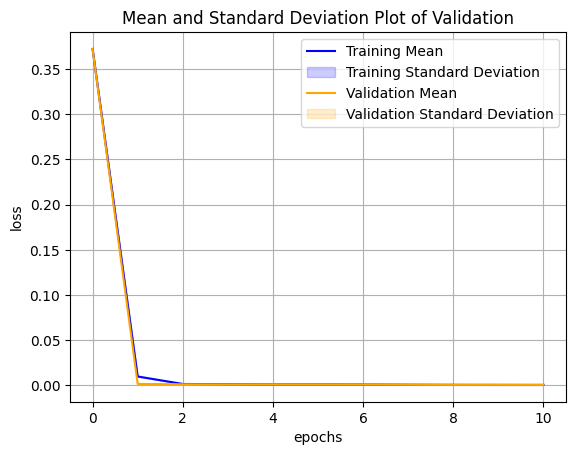

In [32]:
# Defining the Plot Style

# Plotting
if num_runs != 0:
    with torch.no_grad():
        plot_mean_and_std(losses_2d, "blue", "Training")
        plot_mean_and_std(val_losses_2d, "orange", "Validation")

### Quantitative (overall baseline vs prediction view)
- compare our prediction to baseline in test set in a quantitative manner (rather than looking at an individual heatmap)

In [33]:
if num_runs == 0: ## no training, take from previously saved model
    model = NN()
    model = torch.load("model/next_step_3.pt")

In [34]:
## take in dataframe, return known domain average for prediction, modified from baseline quant 11/04/2024
def known_domain_average(data : pd.DataFrame):
    """
    Imputes missing values (NaN) in a DataFrame with the average of the non-missing values in the same row.

    Parameters:
    - data (pd.DataFrame): The DataFrame to impute.

    Returns:
    - pd.DataFrame: The DataFrame with missing values imputed.
    """
    assert(data.shape[1] == 14 * 2) ## make sure that the dataframe is the right shape with encoding, current, and target

    # separate encoding, scores, and target (which we dont need so ignored in here)
    encoding = data.iloc[:, :14].copy()
    data_ = data.iloc[:, 14:28].copy()

    # Replace '0' with NaN to handle them as missing values
    data_ = data.replace(0, np.nan)
    # initialize the list we are going to use to store all known domain average
    known_domain_average_lst = []

    # Iterate over each row
    for index, row in data_.iterrows():
        # Calculate the mean of the non-NaN values in the row
        mean_value = row.mean()
        # if there are no known domains, we say known domain average is 0
        if np.isnan(mean_value):
            mean_value = 0
        # append the average onto the list
        known_domain_average_lst.append(mean_value)
        # in the encoding df, replace na with 
        encoding.loc[index] = encoding.loc[index].replace(1, mean_value)
    
    return encoding

In [35]:
def get_accuracy(y_pred, y_true, n, fn : str):
    diff = y_pred - y_true
    if fn == "mse":
        return np.sum(np.power(diff, 2)) / n
    elif fn == "mae":
        return np.sum(np.abs(diff)) / n

In [36]:
# get predictions from the model
def predict(data, model):
    model.eval()
    data_t = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        return model(data_t).clone().detach().numpy()

In [37]:
from scipy.stats import sem

accuracy_list_prediction_sq = []
accuracy_list_knownimputation_sq = []
accuracy_list_prediction_abs = []
accuracy_list_knownimputation_abs = []

for masked_number in range(14):
    # Count the number of rows with exactly 'masked_number' missing values (indicated by 0)
    masked_rows = (test_data[score_columns] == 0).sum(axis=1) == masked_number
    masked_test_data = test_data[masked_rows]
    
    if masked_test_data.shape[0] == 0:
        # If no rows have the required number of missing values, append NaN and continue
        accuracy_list_prediction_abs.append(np.nan)
        accuracy_list_knownimputation_abs.append(np.nan)
        accuracy_list_prediction_sq.append(np.nan)
        accuracy_list_knownimputation_sq.append(np.nan)
        continue

    # known domain average prediction for the next domains
    baseline_prediction = known_domain_average(masked_test_data[encoding_columns + score_columns]).to_numpy()

    # predict
    masked_test_data_ = copy.deepcopy(masked_test_data[encoding_columns + score_columns])
    masked_test_data_ = masked_test_data_.to_numpy()
    test_data_scores = create_missing_indicator(masked_test_data_[:, -14:])
    masked_test_data_ = np.hstack((masked_test_data_[:, :14], test_data_scores))
    model_prediction = predict(masked_test_data_, model)
    model_prediction = np.multiply(model_prediction, masked_test_data[encoding_columns].to_numpy()) # element wise multiply the two so we have the same form as baseline prediction
    # we only have the values we are predicting in the matrix, everything else is 0

    # get accuracy (abs)
    original = masked_test_data[target_columns].copy().to_numpy() # ground truth
    original = np.multiply(original, masked_test_data[encoding_columns].copy().to_numpy()) # element wise multiply the two so we only have the scores we care about predicting
    assert original.shape == model_prediction.shape and original.shape == baseline_prediction.shape
    n_predicting = np.sum(masked_test_data[encoding_columns].copy().to_numpy())

    accuracy_list_prediction_abs.append(get_accuracy(model_prediction, original, n_predicting, "mae"))
    accuracy_list_knownimputation_abs.append(get_accuracy(baseline_prediction, original, n_predicting, "mae"))

    # get accuracy (sq)
    accuracy_list_prediction_sq.append(get_accuracy(model_prediction, original, n_predicting, "mse"))
    accuracy_list_knownimputation_sq.append(get_accuracy(baseline_prediction, original, n_predicting, "mse"))

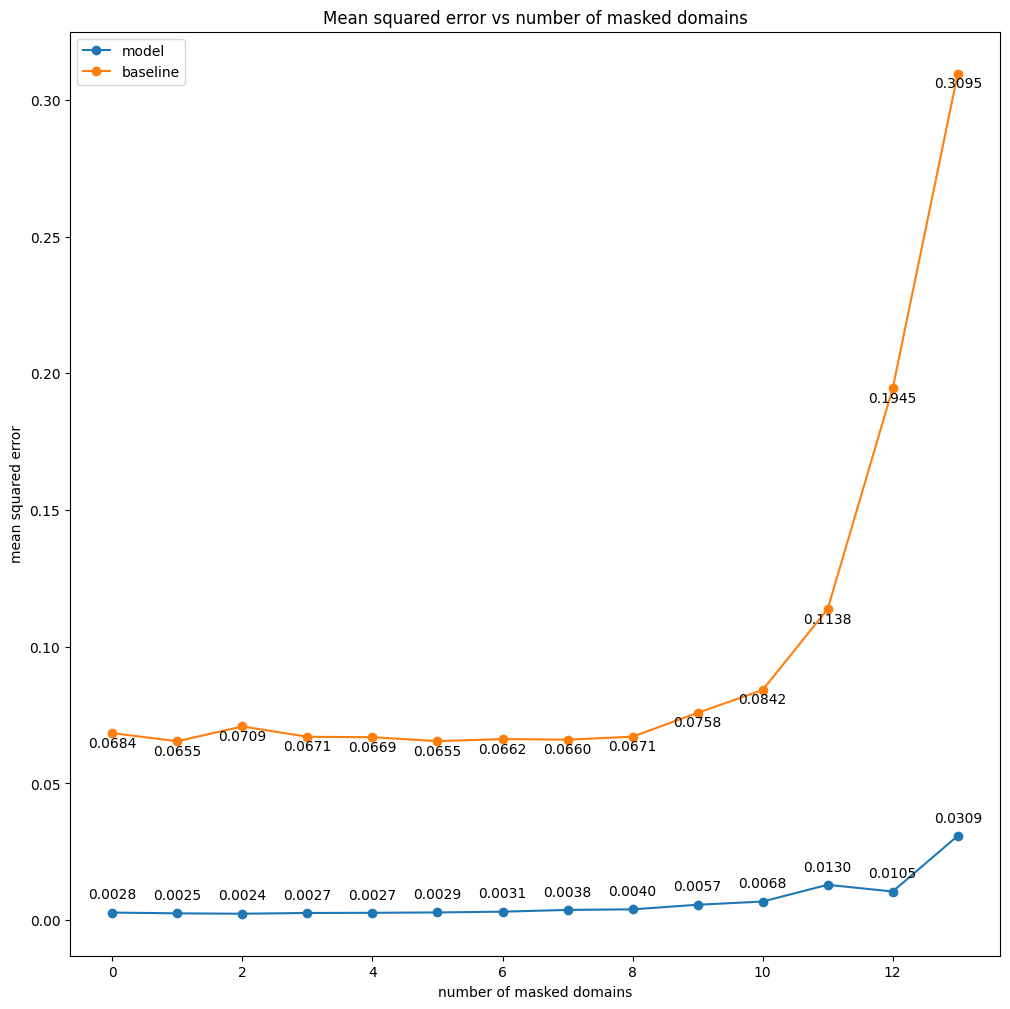

In [38]:
fig = plt.figure(figsize=(12, 12))
# plt.errorbar(range(0, 14), accuracy_list_prediction_sq, yerr=error_prediction_sq, label="model", linewidth=3)
# plt.errorbar(range(0, 14), accuracy_list_imputation_sq, yerr=error_imputation_sq, label="baseline")

x_values = range(0, 14)

plt.plot(x_values, accuracy_list_prediction_sq, label="model", marker="o")
plt.plot(x_values, accuracy_list_knownimputation_sq, label="baseline", marker="o")

for x, y1, y2 in zip(x_values, accuracy_list_prediction_sq, accuracy_list_knownimputation_sq):
    offset = 10

    label = "{:.4f}".format(y1)
    plt.annotate(label, # this is the text
                (x,y1), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    
    label = "{:.4f}".format(y2)
    plt.annotate(label, # this is the text
                (x,y2), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,-10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center



plt.xlabel("number of masked domains")
plt.ylabel("mean squared error")
plt.title("Mean squared error vs number of masked domains")
plt.legend()

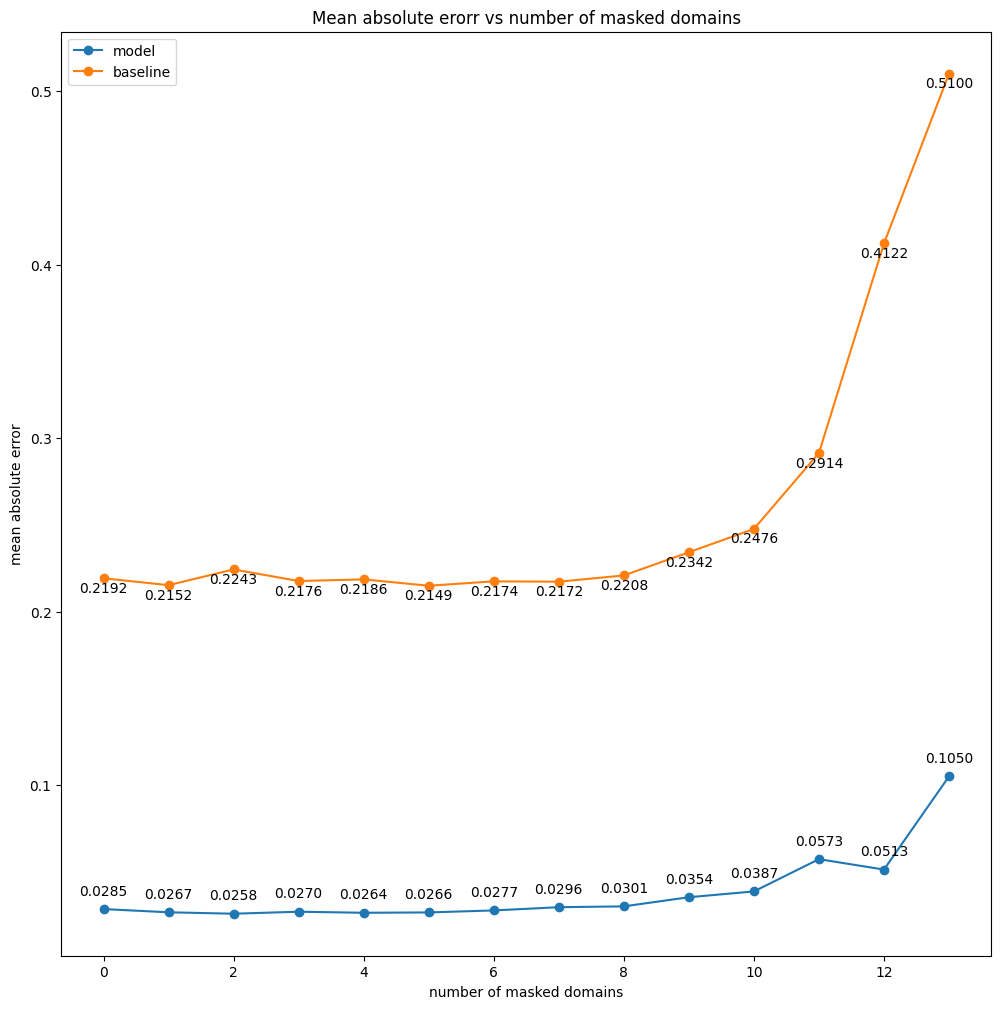

In [39]:
fig = plt.figure(figsize=(12, 12))
# plt.errorbar(range(0, 14), accuracy_list_prediction_abs, yerr=error_prediction_abs, label="prediction", linewidth=3)
# plt.errorbar(range(0, 14), accuracy_list_imputation_abs, yerr=error_imputation_abs, label="imputation")
x_values = range(0, 14)

plt.plot(x_values, accuracy_list_prediction_abs, label="model", marker="o")
plt.plot(x_values, accuracy_list_knownimputation_abs, label="baseline", marker="o")

for x, y1, y2 in zip(x_values, accuracy_list_prediction_abs, accuracy_list_knownimputation_abs):

    label = "{:.4f}".format(y1)
    plt.annotate(label, # this is the text
                (x,y1), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    
    label = "{:.4f}".format(y2)
    plt.annotate(label, # this is the text
                (x,y2), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,-10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    

plt.xlabel("number of masked domains")
plt.ylabel("mean absolute error")
plt.title("Mean absolute erorr vs number of masked domains")
plt.legend()

### Visualization
- visualize individual patient's trajectory (ground truth vs prediction vs imputation?)
- look at overall quantitative picture

In [40]:
column_names = ["domain %d score" % i for i in range(1, 15)]
column_rename_dict = {}
for i in range(len(column_names)):
    column_rename_dict[column_names[i]] = i + 1

In [41]:
# takes in a matrix, returns a list mean along rows
def get_score(data):
    return np.mean(data, axis=1)

In [42]:
# get ground truth scores (overall)
GT_scores = get_score(case_study_data[column_names].to_numpy())

In [43]:
# get prediction scores
model.eval()
with torch.no_grad():
    test_data_case = case_study_data[encoding_columns + score_columns].to_numpy()
    test_data_scores = create_missing_indicator(test_data_case[:, -14:])
    test_data_case = np.hstack((test_data_case[:, :14], test_data_scores))
    predictions = model(torch.from_numpy(test_data_case).type(torch.float32)).detach().numpy()

In [44]:
n_missing = np.sum(case_study_data[encoding_columns].to_numpy())
target_ = np.multiply(case_study_data[target_columns].to_numpy(), case_study_data[encoding_columns].to_numpy()) # only the targets we want to predict
prediction_ = np.multiply(predictions, case_study_data[encoding_columns].to_numpy()) # only the scores we want to predict
mse_ = np.divide(np.sum(np.abs(target_ - prediction_)), n_missing)

In [45]:
# mask for which columns we are trying to predict
mask = case_study_data[encoding_columns].to_numpy()

In [46]:
prediction_only = pd.DataFrame(mask * predictions, columns=column_names)
target_only = pd.DataFrame(mask * case_study_data[target_columns].to_numpy(), columns=column_names)

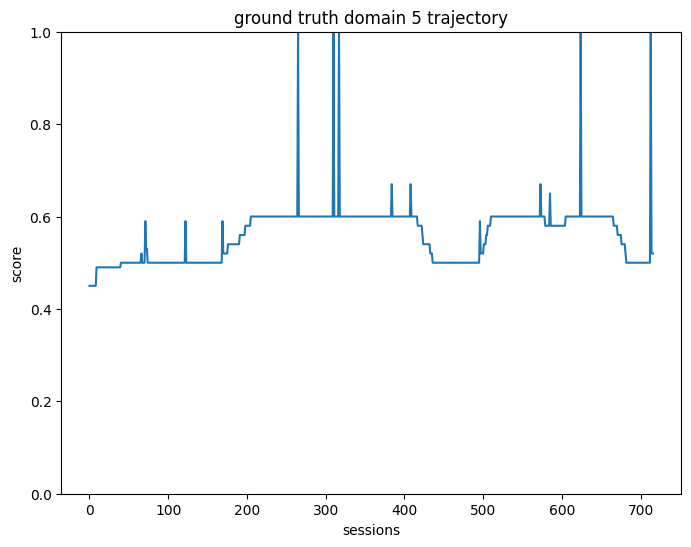

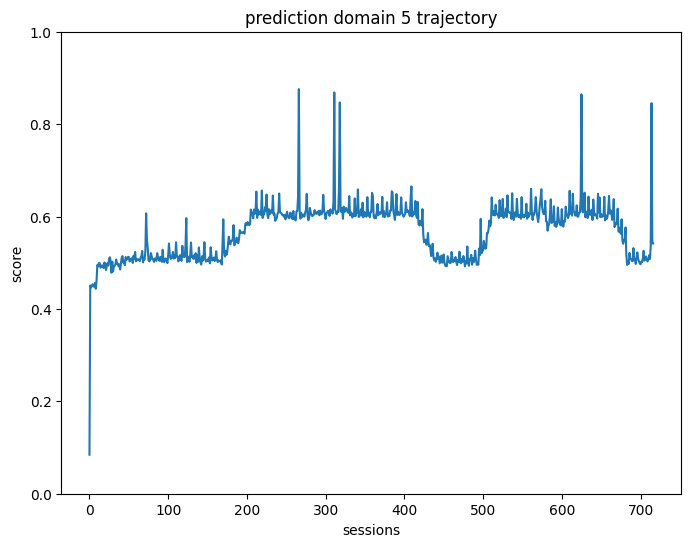

In [47]:
domain_ = 5

## plot specific domain progression
# Plot
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
plot = ax.plot(range(case_study_data.shape[0]), case_study_data["domain %d target" % domain_])
# Set the y-axis range from -1 to 1
ax.set_ylim(0, 1)
plt.title("ground truth domain %d trajectory" % domain_)
plt.xlabel("sessions")
plt.ylabel("score")
plt.show()

# Plot
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
plot = ax.plot(range(case_study_data.shape[0]), predictions[:, domain_ - 1])
# Set the y-axis range from -1 to 1
ax.set_ylim(0, 1)
plt.title("prediction domain %d trajectory" % domain_)
plt.xlabel("sessions")
plt.ylabel("score")
plt.show()

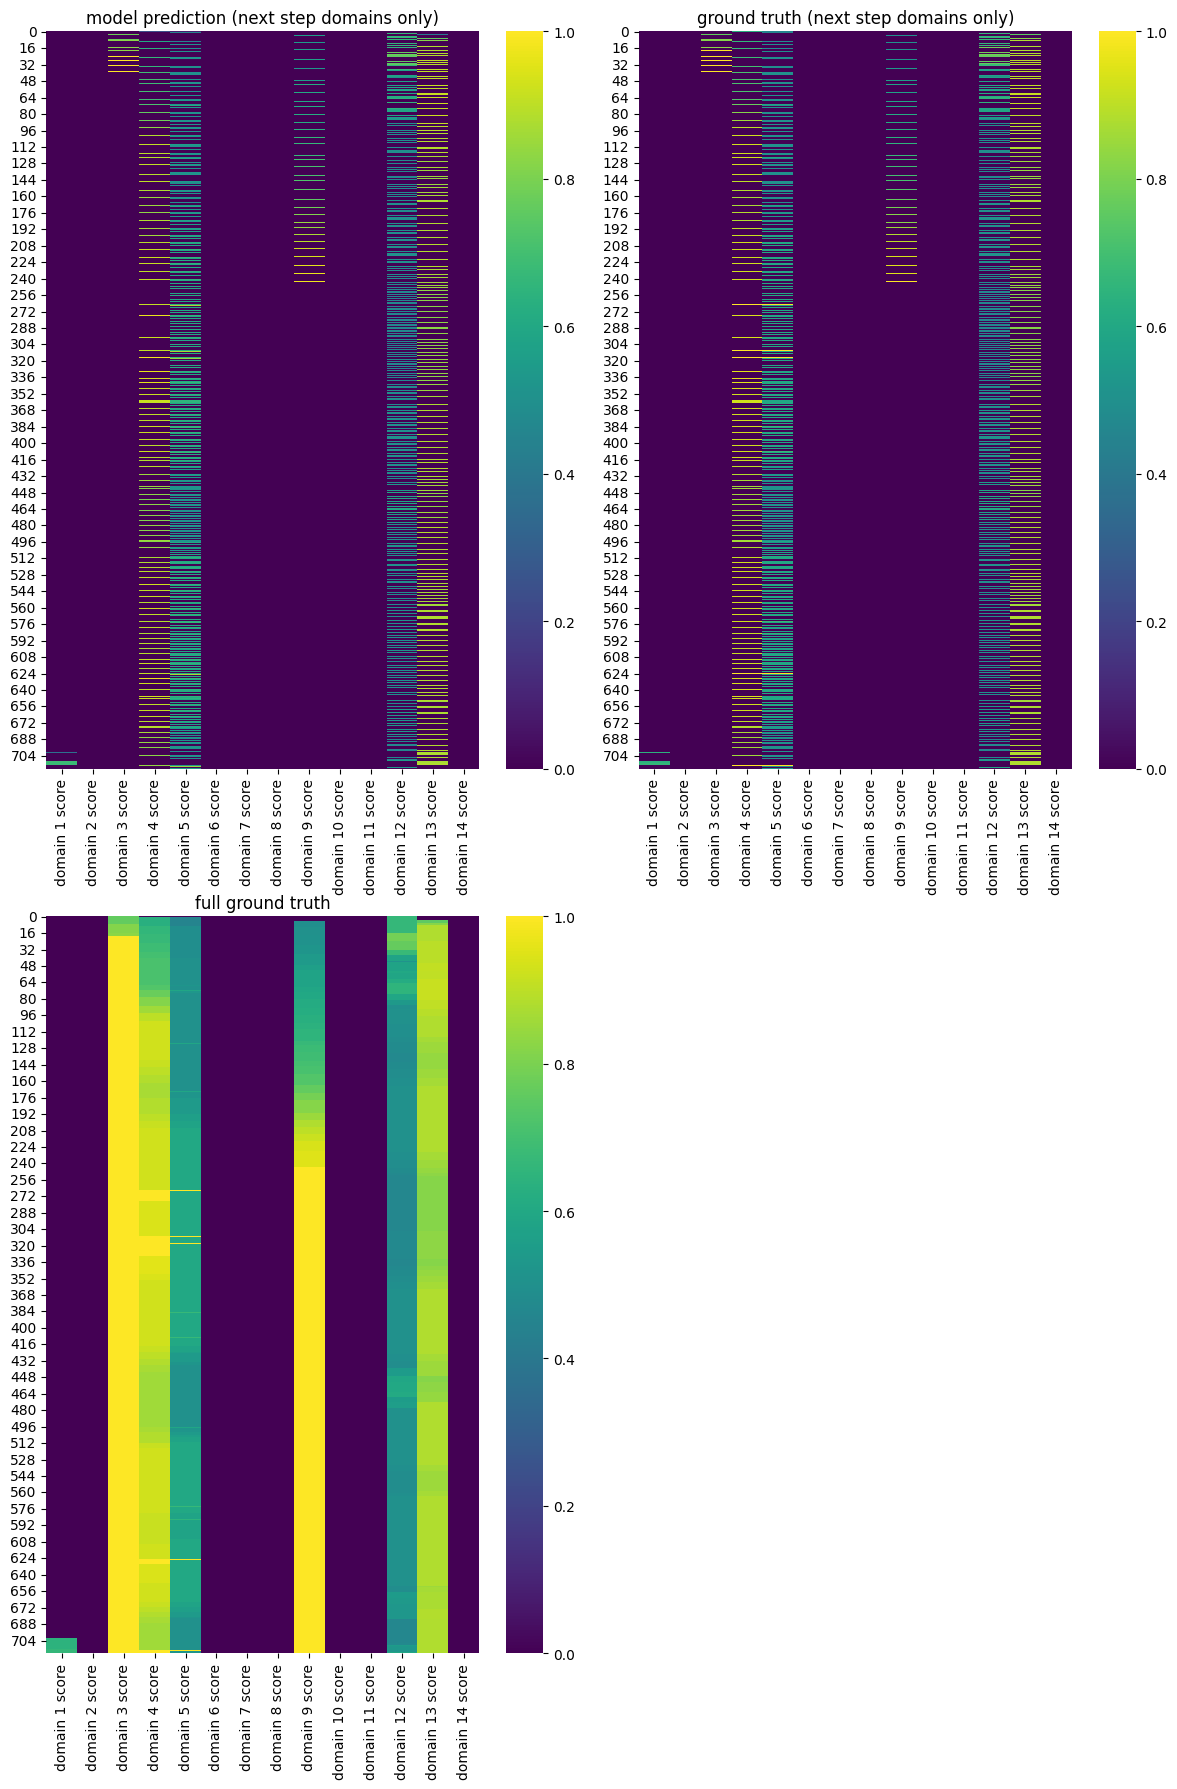

In [48]:
fig = plt.figure(figsize=(12, 18))
vmin = 0
vmax = 1

plt.subplot(2, 2, 1)
sns.heatmap(prediction_only, cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("model prediction (next step domains only)")

plt.subplot(2, 2, 2)
sns.heatmap(target_only, cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("ground truth (next step domains only)")

plt.subplot(2, 2, 3)
sns.heatmap(case_study_data[score_columns], cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("full ground truth")

fig.tight_layout()
fig.subplots_adjust(hspace=0.2)

In [49]:
np.unique(df[df.patient_id == pid]["domain_ids"])

array(['1,13', '12', '12,13', '13', '3,12', '3,13', '4,5', '5', '9'],
      dtype=object)

In [50]:
create_training_data(df[df.patient_id == pid])

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 6 target,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat
0,147893.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.665,0.000,0.0,0.0
1,147893.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.665,0.000,0.0,1.0
2,147893.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.665,0.000,0.0,1.0
3,147893.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.665,0.752,0.0,0.0
4,147893.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.49,0.0,0.0,0.665,0.752,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,147893.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.00,0.0,0.0,0.528,0.879,0.0,1.0
713,147893.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.00,0.0,0.0,0.528,0.879,0.0,1.0
714,147893.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.00,0.0,0.0,0.528,0.879,0.0,1.0
715,147893.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.00,0.0,0.0,0.593,0.879,0.0,1.0


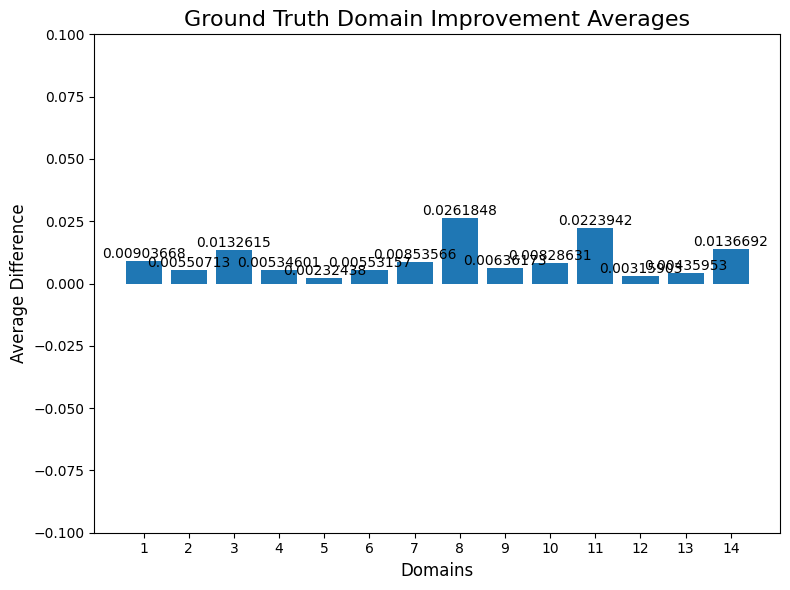

In [51]:
## ground truth
diff = test_data[target_columns].to_numpy() * test_data[encoding_columns].to_numpy() - test_data[score_columns].to_numpy() * test_data[encoding_columns].to_numpy()


# Calculate column-wise averages
column_averages = np.sum(diff, axis=0) / np.sum(test_data[encoding_columns].to_numpy(), axis=0)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
bars = ax.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])

# Add values to the bars
ax.bar_label(bars, label_type='edge')

# Set the y-axis range from -1 to 1
ax.set_ylim(-0.1, 0.1)

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Ground Truth Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [52]:
# store model as 
torch.save(model, "model/next_step_5.pt")

In [53]:
test_data_input = test_data[encoding_columns + score_columns].copy().to_numpy()
test_data_scores = create_missing_indicator(test_data_input[:, -14:])
test_data_input = np.hstack((test_data_input[:, :14], test_data_scores))

In [54]:
predictions = model(torch.from_numpy(test_data_input).float())

In [55]:
diff = predictions.detach().numpy() * test_data[encoding_columns].to_numpy() - test_data[score_columns].to_numpy() * test_data[encoding_columns].to_numpy()

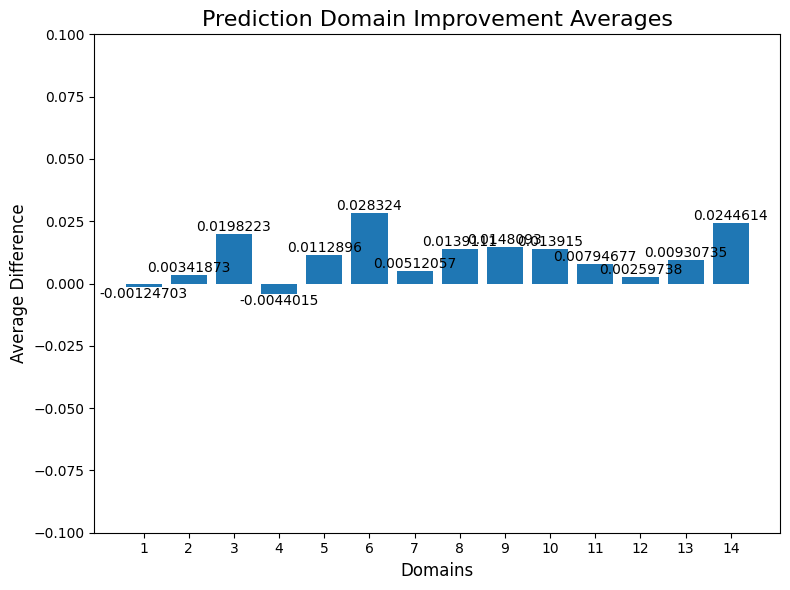

In [56]:
# Calculate column-wise averages
column_averages = np.sum(diff, axis=0) / np.sum(test_data[encoding_columns].to_numpy(), axis=0)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
bars = ax.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])

# Add values to the bars
ax.bar_label(bars, label_type='edge')

# Set the y-axis range from -1 to 1
ax.set_ylim(-0.1, 0.1)

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Prediction Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [57]:
diff.shape

(547243, 14)

In [58]:
repeat_test = test_data[repeat_columns].to_numpy().copy().flatten()
repeat_test.shape

(547243,)

In [59]:
repeats_diff = diff[repeat_test == 1]
non_repeats_diff = diff[repeat_test == 0]

In [60]:
repeats_n = test_data[encoding_columns].to_numpy()[repeat_test == 1]
non_repeats_n = test_data[encoding_columns].to_numpy()[repeat_test == 0]

In [61]:
repeats_diff_gt = test_data[repeat_test == 1][target_columns].to_numpy() * test_data[repeat_test == 1][encoding_columns].to_numpy() - test_data[repeat_test == 1][score_columns].to_numpy() * test_data[repeat_test == 1][encoding_columns].to_numpy()
non_repeat_diff_gt = test_data[repeat_test == 0][target_columns].to_numpy() * test_data[repeat_test == 0][encoding_columns].to_numpy() - test_data[repeat_test == 0][score_columns].to_numpy() * test_data[repeat_test == 0][encoding_columns].to_numpy()

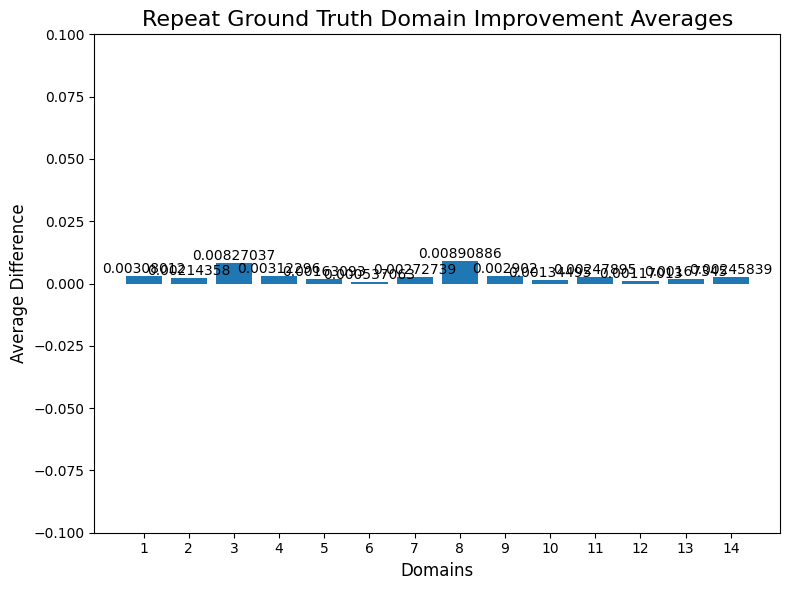

In [62]:
# Calculate column-wise averages
column_averages = np.sum(repeats_diff_gt, axis=0) / np.sum(repeats_n, axis=0)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
bars = ax.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])

# Add values to the bars
ax.bar_label(bars, label_type='edge')

# Set the y-axis range from -1 to 1
ax.set_ylim(-0.1, 0.1)

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Repeat Ground Truth Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

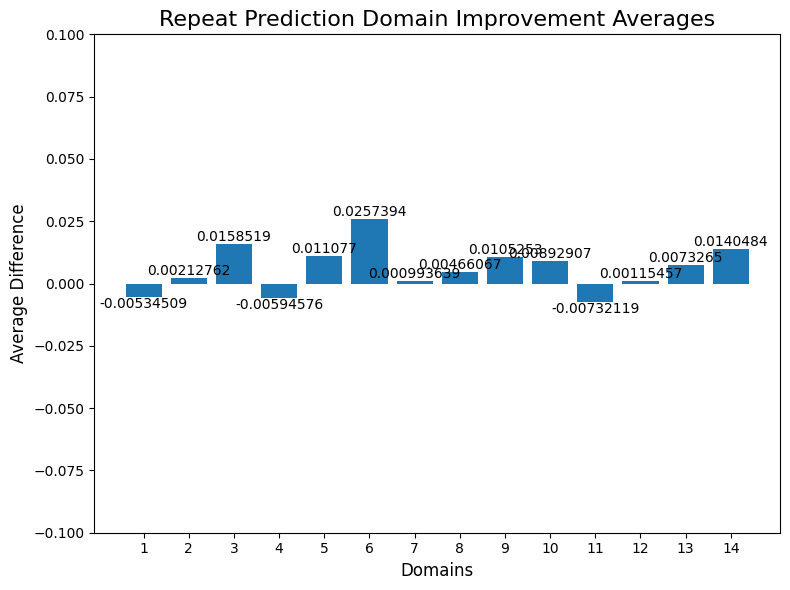

In [63]:
# Calculate column-wise averages
column_averages = np.sum(repeats_diff, axis=0) / np.sum(repeats_n, axis=0)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
bars = ax.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])

# Add values to the bars
ax.bar_label(bars, label_type='edge')

# Set the y-axis range from -1 to 1
ax.set_ylim(-0.1, 0.1)

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Repeat Prediction Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

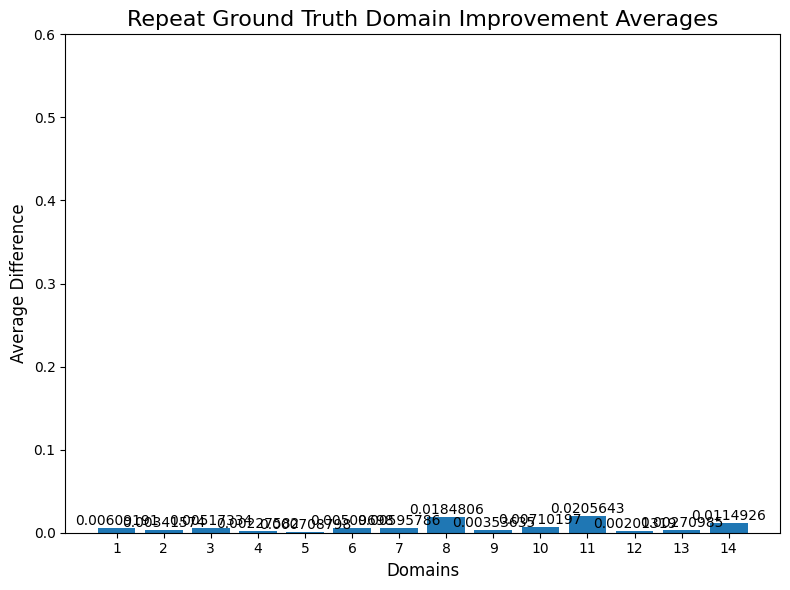

In [64]:
# Calculate column-wise averages
column_averages = np.sum(non_repeat_diff_gt, axis=0) / np.sum(repeats_n, axis=0)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
bars = ax.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])

# Add values to the bars
ax.bar_label(bars, label_type='edge')

# Set the y-axis range from -1 to 1
ax.set_ylim(0, 0.6)

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Repeat Ground Truth Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

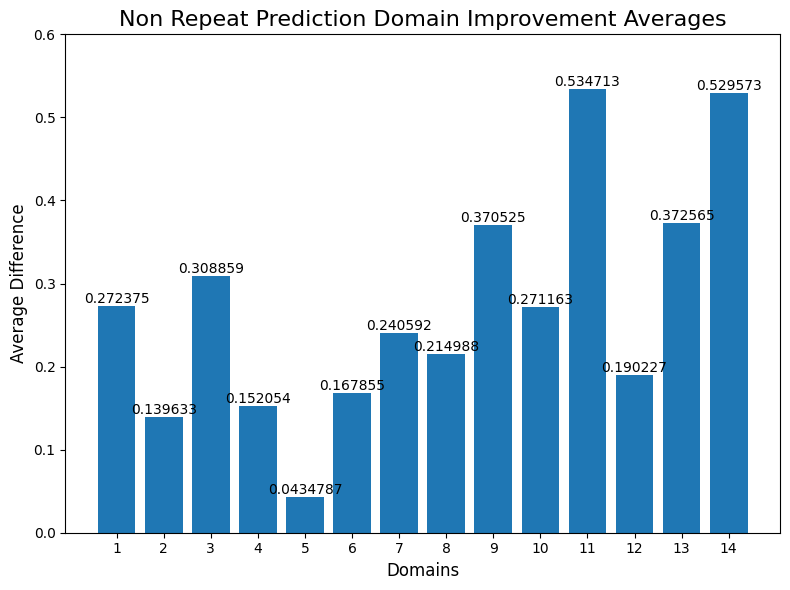

Bad pipe message: %s [b'>\x9c\xa3\xca{\xf5c\x83\xdc\xd2^\x95\xf5\xcaZ%?.\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0', b'\x07\xc0\x08\xc0\t']
Bad pipe message: %s [b"\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\xc0#\

In [65]:
# Calculate column-wise averages
column_averages = np.sum(non_repeats_diff, axis=0) / np.sum(non_repeats_n, axis=0)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))  # Create the figure and axes
bars = ax.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])

# Add values to the bars
ax.bar_label(bars, label_type='edge')

# Set the y-axis range from -1 to 1
ax.set_ylim(0, 0.6)

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Non Repeat Prediction Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()